# Q6

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from itertools import chain
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb


## a)

In [2]:
from os import listdir
from os.path import isfile, join
import re
num=re.compile(r"a([0-9]+)\.txt")

listfiles = [f for f in listdir("p5-data/sotu/files/") if isfile(join("p5-data/sotu/files", f))]
def get_number(x):
    return int(num.findall(x)[0])


listfiles=sorted(listfiles,key=get_number)

In [3]:
corpus = []
for fi in listfiles:
    file_path = "p5-data/sotu/files/%s" % (fi)
    with open(file_path) as f:
        corpus.append(f.read())
        f.close()
# flatten list 


In [4]:

# 'content' method (stored corpus object in memory)
vectorizer = CountVectorizer(input='content')
X = vectorizer.fit_transform(corpus)
partiys=open("p5-data/sotu/party.txt").read().splitlines()[0:-1]
partiys_name=[line[0] for line in partiys]

person=re.compile("...(.*), [0-9]+")
person_name=[person.findall(line)[0] for line in partiys]

year=re.compile(".*, ([0-9]+)$")
year_name=[year.findall(line)[0] for line in partiys]

# b

In [5]:
with open("p5-data/sotu/stopwords.txt") as f:
    stopwds = f.read().lower().splitlines()
    f.close()


## remove stop words

In [6]:
vectorizer = CountVectorizer(input='content', 
                             stop_words = stopwds)
X = vectorizer.fit_transform(corpus)

# create Document-Term Matrix / DataFrame
Xframe = pd.DataFrame(X.toarray(), 
                      index=listfiles, 
                      columns=vectorizer.get_feature_names())


/Users/jiangqiushen/.conda/envs/ml/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'aren', 'couldn', 'daren', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'll', 'mayn', 'mightn', 'mon', 'mustn', 'needn', 'oughtn', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


##  C

In [7]:
# build the tranning set
# get the index of Democratic and Republican
vectorizer = CountVectorizer(input='content', 
                             stop_words = stopwds,max_features=3000)
X = vectorizer.fit_transform(corpus)

# create Document-Term Matrix / DataFrame

filter_out=['trump 2017','obama 2014','bush 2006','clinton 1995','kennedy 1962']
file_names=[]
selected_name=[]
selected_person=[]
selected_year=[]
selected_corp=[]
for i in range(231):
    if partiys_name[i]=='r' or partiys_name[i]=='d':
        if not f"{person_name[i]} {year_name[i]}" in filter_out:
            selected_person.append(person_name[i])
            selected_year.append(year_name[i])
            selected_name.append(partiys_name[i])
            selected_corp.append(X[i].toarray().reshape(-1))
            file_names.append(f"a{i+1}.txt")
print(len(selected_person))
selected_corp=np.array(selected_corp)
Xframe = pd.DataFrame(X.toarray(), 
                      index=listfiles, 
                      columns=vectorizer.get_feature_names())
Xfram_traning=pd.DataFrame(selected_corp,index=file_names, 
                      columns=vectorizer.get_feature_names())
                    
print(Xfram_traning.iloc[0:10,0:5])

178
         abandon  abandoned  ability  abolished  abolition
a41.txt        1          1        1          1          0
a42.txt        0          1        3          0          0
a43.txt        0          3        1          1          0
a44.txt        2          0        0          0          1
a45.txt        0          0        0          1          0
a46.txt        2          0        2          0          0
a47.txt        1          0        1          1          0
a48.txt        0          0        1          0          0
a49.txt        0          2        1          0          0
a50.txt        0          2        0          0          0


In [8]:

from sklearn.naive_bayes import BernoulliNB,MultinomialNB
# 0==repu 1==demo
classes=np.array([ 0 if party=='r' else 1 for party in selected_name])
print(classes)
class_name=['republican','democratic']
bnb=BernoulliNB()
# fit the tranning set
print(Xfram_traning.shape)
print(classes.shape)
bnb.fit(Xfram_traning,classes)
print(bnb)
filter_out_index=[230,227,219,208,174]
print(Xframe.shape)
for i in filter_out_index:
    result=bnb.predict_proba(Xframe.to_numpy()[i].reshape(1,-1))
    print(f"real:{person_name[i]}-{year_name[i]} from {partiys_name[i]}, predict: {result}")


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
(178, 3000)
(178,)
BernoulliNB()
(231, 3000)
real:trump-2017 from r, predict: [[2.91360252e-20 1.00000000e+00]]
real:obama-2014 from d, predict: [[1.16164237e-25 1.00000000e+00]]
real:bush-2006 from r, predict: [[6.33504456e-18 1.00000000e+00]]
real:clinton-1995 from d, predict: [[1.15128904e-22 1.00000000e+00]]
real:kennedy-1962 from d, predict: [[2.44231637e-06 9.99997558e-01]]


In [9]:
classes=np.array([ 0 if party=='r' else 1 for party in selected_name])
print(classes)
class_name=['republican','democratic']
bnb=MultinomialNB()
# fit the tranning set
print(Xfram_traning.shape)
print(classes.shape)
bnb.fit(Xfram_traning,classes)
print(bnb)
filter_out_index=[230,227,219,208,174]
print(Xframe.shape)
for i in filter_out_index:
    result=bnb.predict_proba(Xframe.to_numpy()[i].reshape(1,-1))
    print(f"real:{person_name[i]}-{year_name[i]} from {partiys_name[i]}, predict: {result}")


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
(178, 3000)
(178,)
MultinomialNB()
(231, 3000)
real:trump-2017 from r, predict: [[1.99249913e-35 1.00000000e+00]]
real:obama-2014 from d, predict: [[1.90586626e-121 1.00000000e+000]]
real:bush-2006 from r, predict: [[3.34995948e-20 1.00000000e+00]]
real:clinton-1995 from d, predict: [[2.1393714e-93 1.0000000e+00]]
real:kennedy-1962 from d, predict: [[5.06189705e-45 1.00000000e+00]]


In [10]:
#Q7 implement BernoulliNb and MultinomialNB
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
class myBernoulliNB:
    def __init__(self):
        self.is_fit=False
        
        pass
    #input: X:td-array, y:classes 
    def fit(self,X,y):
        self.class_count=dict()
        self.prior=dict()
        for c in y:
            if c in self.class_count:
                self.class_count[c]=self.class_count[c]+1
            else:
                self.class_count[c]=1

        self.N=X.shape[0]
        
        for key in self.class_count:
            self.prior[key]=self.class_count[key]/self.N
        #for each vocabulary
        self.condprob=np.zeros([X.shape[1],len(self.class_count)])
        for i in range(X.shape[1]):
            for key in self.class_count:
                Nc=self.class_count[key]
                # i is the vocabuler, key is the class number
                Nct=0
                for j in range(self.N):
                    if y[j]==key and X[j,i]!=0:
                        Nct+=1
                self.condprob[i][key]=(Nct+1)/(Nc+2)
        self.is_fit=True
        pass
    #input X: a singe document TD vector
    def predict_prob_log(self,X):
        if not self.is_fit:
            print("fit before predict")
            return None

        scores=[]
        for i in range(X.shape[0]):
            score=np.zeros(len(self.class_count))

            for key in self.class_count:
                score[key]=np.log(self.prior[key])
                for j in range(X.shape[1]):
                    if X[i,j]!=0:
                        score[c]+=np.log(self.condprob[j][key])
                    else:
                        score[c]+=np.log(1-self.condprob[j][key])
            scores.append(score)

        return np.array(scores,dtype=float)
        pass

    def predict_prob(self,X):
        log=self.predict_prob_log(X)
        return np.exp(log,dtype=float)
    pass


class myMultinomialNB:
    def __init__(self):
        self.is_fit=False

        pass
    def fit(self,X,y):
        self.class_count=dict()
        self.prior=dict()
        for c in y:
            if c in self.class_count:
                self.class_count[c]=self.class_count[c]+1
            else:
                self.class_count[c]=1

        self.N=X.shape[0]
        
        for key in self.class_count:
            self.prior[key]=self.class_count[key]/self.N
        #for each vocabulary
        self.condprob=np.zeros([X.shape[1],len(self.class_count)])
        
        for key in self.class_count:
            Nc=self.class_count[key]
            
            Nctt=0
            for j in range(self.N):
                if y[j]==key:
                    Nctt+=np.sum(X[j])
            for i in range(X.shape[1]):
                #print("word",i)
                # i is the vocabuler, key is the class number
                Nct=0
                for j in range(self.N):
                    if y[j]==key and X[j,i]!=0:
                        Nct+=X[j,i]

                self.condprob[i][key]=(Nct+1)/(Nctt+X.shape[1])
        self.is_fit=True
        pass
    
    #input X: a singe document TD vector
    def predict_prob_log(self,X):
        if not self.is_fit:
            print("fit before predict")
            return None

        scores=[]
        for i in range(X.shape[0]):
            score=np.zeros(len(self.class_count))

            for key in self.class_count:
                #print("key,prior",key,self.prior[key])
                score[key]=np.log(self.prior[key])
                for j in range(X.shape[1]):
                    if X[i,j]!=0:
                        #print("cond,j,key",self.condprob[j][key],X[i,j])
                        score[key]+=np.log(self.condprob[j][key])*X[i,j]


                        
            scores.append(score)

        return np.array(scores,dtype=float)
        pass

    def predict_prob(self,X):
        log=self.predict_prob_log(X)
        return np.exp(log,dtype=float)
    pass

    pass

docs=["chinese beijing chinese","chinese chinese shanghai","chinese macao","tokyo japan chinese","chinese chinese chinese tokyo japan"]
c=[1,1,1,0]
vectorizer = CountVectorizer(input='content')
X_simple_test=vectorizer.fit_transform(docs)
print(vectorizer.vocabulary_)
print(X_simple_test)
# the sklearn result



{'chinese': 1, 'beijing': 0, 'shanghai': 4, 'macao': 3, 'tokyo': 5, 'japan': 2}
  (0, 1)	2
  (0, 0)	1
  (1, 1)	2
  (1, 4)	1
  (2, 1)	1
  (2, 3)	1
  (3, 1)	1
  (3, 5)	1
  (3, 2)	1
  (4, 1)	3
  (4, 5)	1
  (4, 2)	1


In [11]:
# test the model
# first the sklearn result
m=myBernoulliNB()
m.fit(X_simple_test[0:4],c)
print(m.predict_prop(X_simple_test[4]))

m=myMultinomialNB()
m.fit(X_simple_test[0:4],c)
m.predict_prop(X_simple_test[4])




AttributeError: 'myBernoulliNB' object has no attribute 'predict_prop'

In [142]:
# test the Q7

m=myBernoulliNB()
m.fit(selected_corp,classes)
filter_out_index=[230,227,219,208,174]
print(selected_corp)
for i in filter_out_index:
    result=m.predict_prob_log(X[i].reshape(1,-1))
    print(f"real:{person_name[i]}-{year_name[i]} from {partiys_name[i]}, predict: {result}")

m=myMultinomialNB()
m.fit(selected_corp,classes)
filter_out_index=[230,227,219,208,174]
print(selected_corp)
for i in filter_out_index:
    result=m.predict_prob_log(X[i].reshape(1,-1))
    print(f"real:{person_name[i]}-{year_name[i]} from {partiys_name[i]}, predict: {result}")


[[1 1 1 ... 0 0 1]
 [0 1 3 ... 0 0 2]
 [0 3 1 ... 0 0 0]
 ...
 [0 0 3 ... 0 0 0]
 [1 0 0 ... 2 0 0]
 [0 0 0 ... 2 0 0]]
real:trump-2017 from r, predict: [[-1565.90456574 -3086.12237318]]
real:obama-2014 from d, predict: [[-1694.88505685 -3331.65087448]]
real:bush-2006 from r, predict: [[-1613.18172459 -3186.05856762]]
real:clinton-1995 from d, predict: [[-1553.86435364 -3056.50827072]]
real:kennedy-1962 from d, predict: [[-1647.4674667  -3281.30792546]]
[[1 1 1 ... 0 0 1]
 [0 1 3 ... 0 0 2]
 [0 3 1 ... 0 0 0]
 ...
 [0 0 3 ... 0 0 0]
 [1 0 0 ... 2 0 0]
 [0 0 0 ... 2 0 0]]
real:trump-2017 from r, predict: [[-11341.66862888 -11261.76754032]]
real:obama-2014 from d, predict: [[-16958.091637   -16680.12377738]]
real:bush-2006 from r, predict: [[-13655.57722067 -13610.73446706]]
real:clinton-1995 from d, predict: [[-15077.12097302 -14863.74107142]]
real:kennedy-1962 from d, predict: [[-16134.32802602 -16032.33343816]]


In [161]:
#Q8 congress
from sklearn.preprocessing import StandardScaler

data_frame_116=pd.read_csv("p5-data/congress/H116_votes.csv")
data_frame_116_cut=data_frame_116.iloc[:,8:]
data_frame_116_trans=StandardScaler().fit_transform(data_frame_116_cut)
data_frame_116_trans=pd.DataFrame(data_frame_116_trans,columns=data_frame_116_cut.columns)

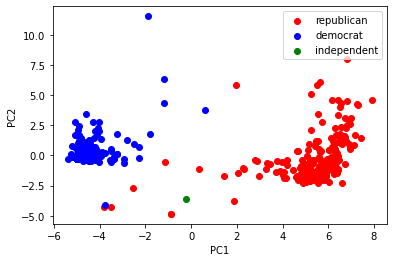

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(data_frame_116_trans)
X=pca.transform(data_frame_116_trans)

fig,ax=plt.subplots()
color_map={200:"r",100:"b",328:"g"}
label_map={200:"republican",100:"democrat",328:"independent"}

for code in [200,100,328]:
    index=np.where(data_frame_116['PartyCode']==code)
    ax.scatter(X[index,0],X[index,1],c=color_map[code],label=label_map[code])

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()

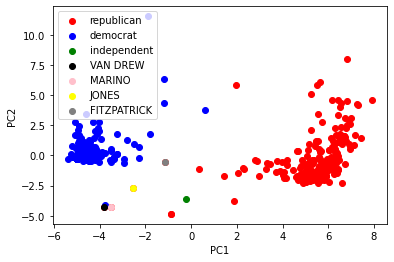

In [203]:
index=np.where(data_frame_116['PartyCode']==200)

sub_index=np.argsort(X[index,0])[0][0:4]
abs_index=index[0][sub_index]
fig,ax=plt.subplots()
colors=['black','pink','yellow','gray']
start=0
for code in [200,100,328]:
    index=np.where(data_frame_116['PartyCode']==code)
    ax.scatter(X[index,0],X[index,1],c=color_map[code],label=label_map[code])
for i in abs_index:
    ax.scatter(X[i,0],X[i,1],c=colors[start],marker="o",label=data_frame_116['Name'][i])
    start+=1

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()

Van Drew change parties from Republican to Democrat
 

No handles with labels found to put in legend.


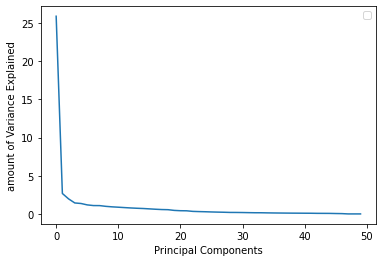

In [205]:
fig,ax=plt.subplots()
ax.plot(pca.explained_variance_)
ax.set_xlabel("Principal Components")
ax.set_ylabel("amount of Variance Explained")
ax.legend()

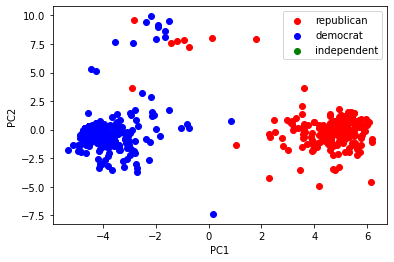

In [206]:

data_frame_116=pd.read_csv("p5-data/congress/H110_votes.csv")
data_frame_116_cut=data_frame_116.iloc[:,8:]
data_frame_116_trans=StandardScaler().fit_transform(data_frame_116_cut)
data_frame_116_trans=pd.DataFrame(data_frame_116_trans,columns=data_frame_116_cut.columns)


pca = PCA()
pca.fit(data_frame_116_trans)
X=pca.transform(data_frame_116_trans)

fig,ax=plt.subplots()
color_map={200:"r",100:"b",328:"g"}
label_map={200:"republican",100:"democrat",328:"independent"}

for code in [200,100,328]:
    index=np.where(data_frame_116['PartyCode']==code)
    ax.scatter(X[index,0],X[index,1],c=color_map[code],label=label_map[code])

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()

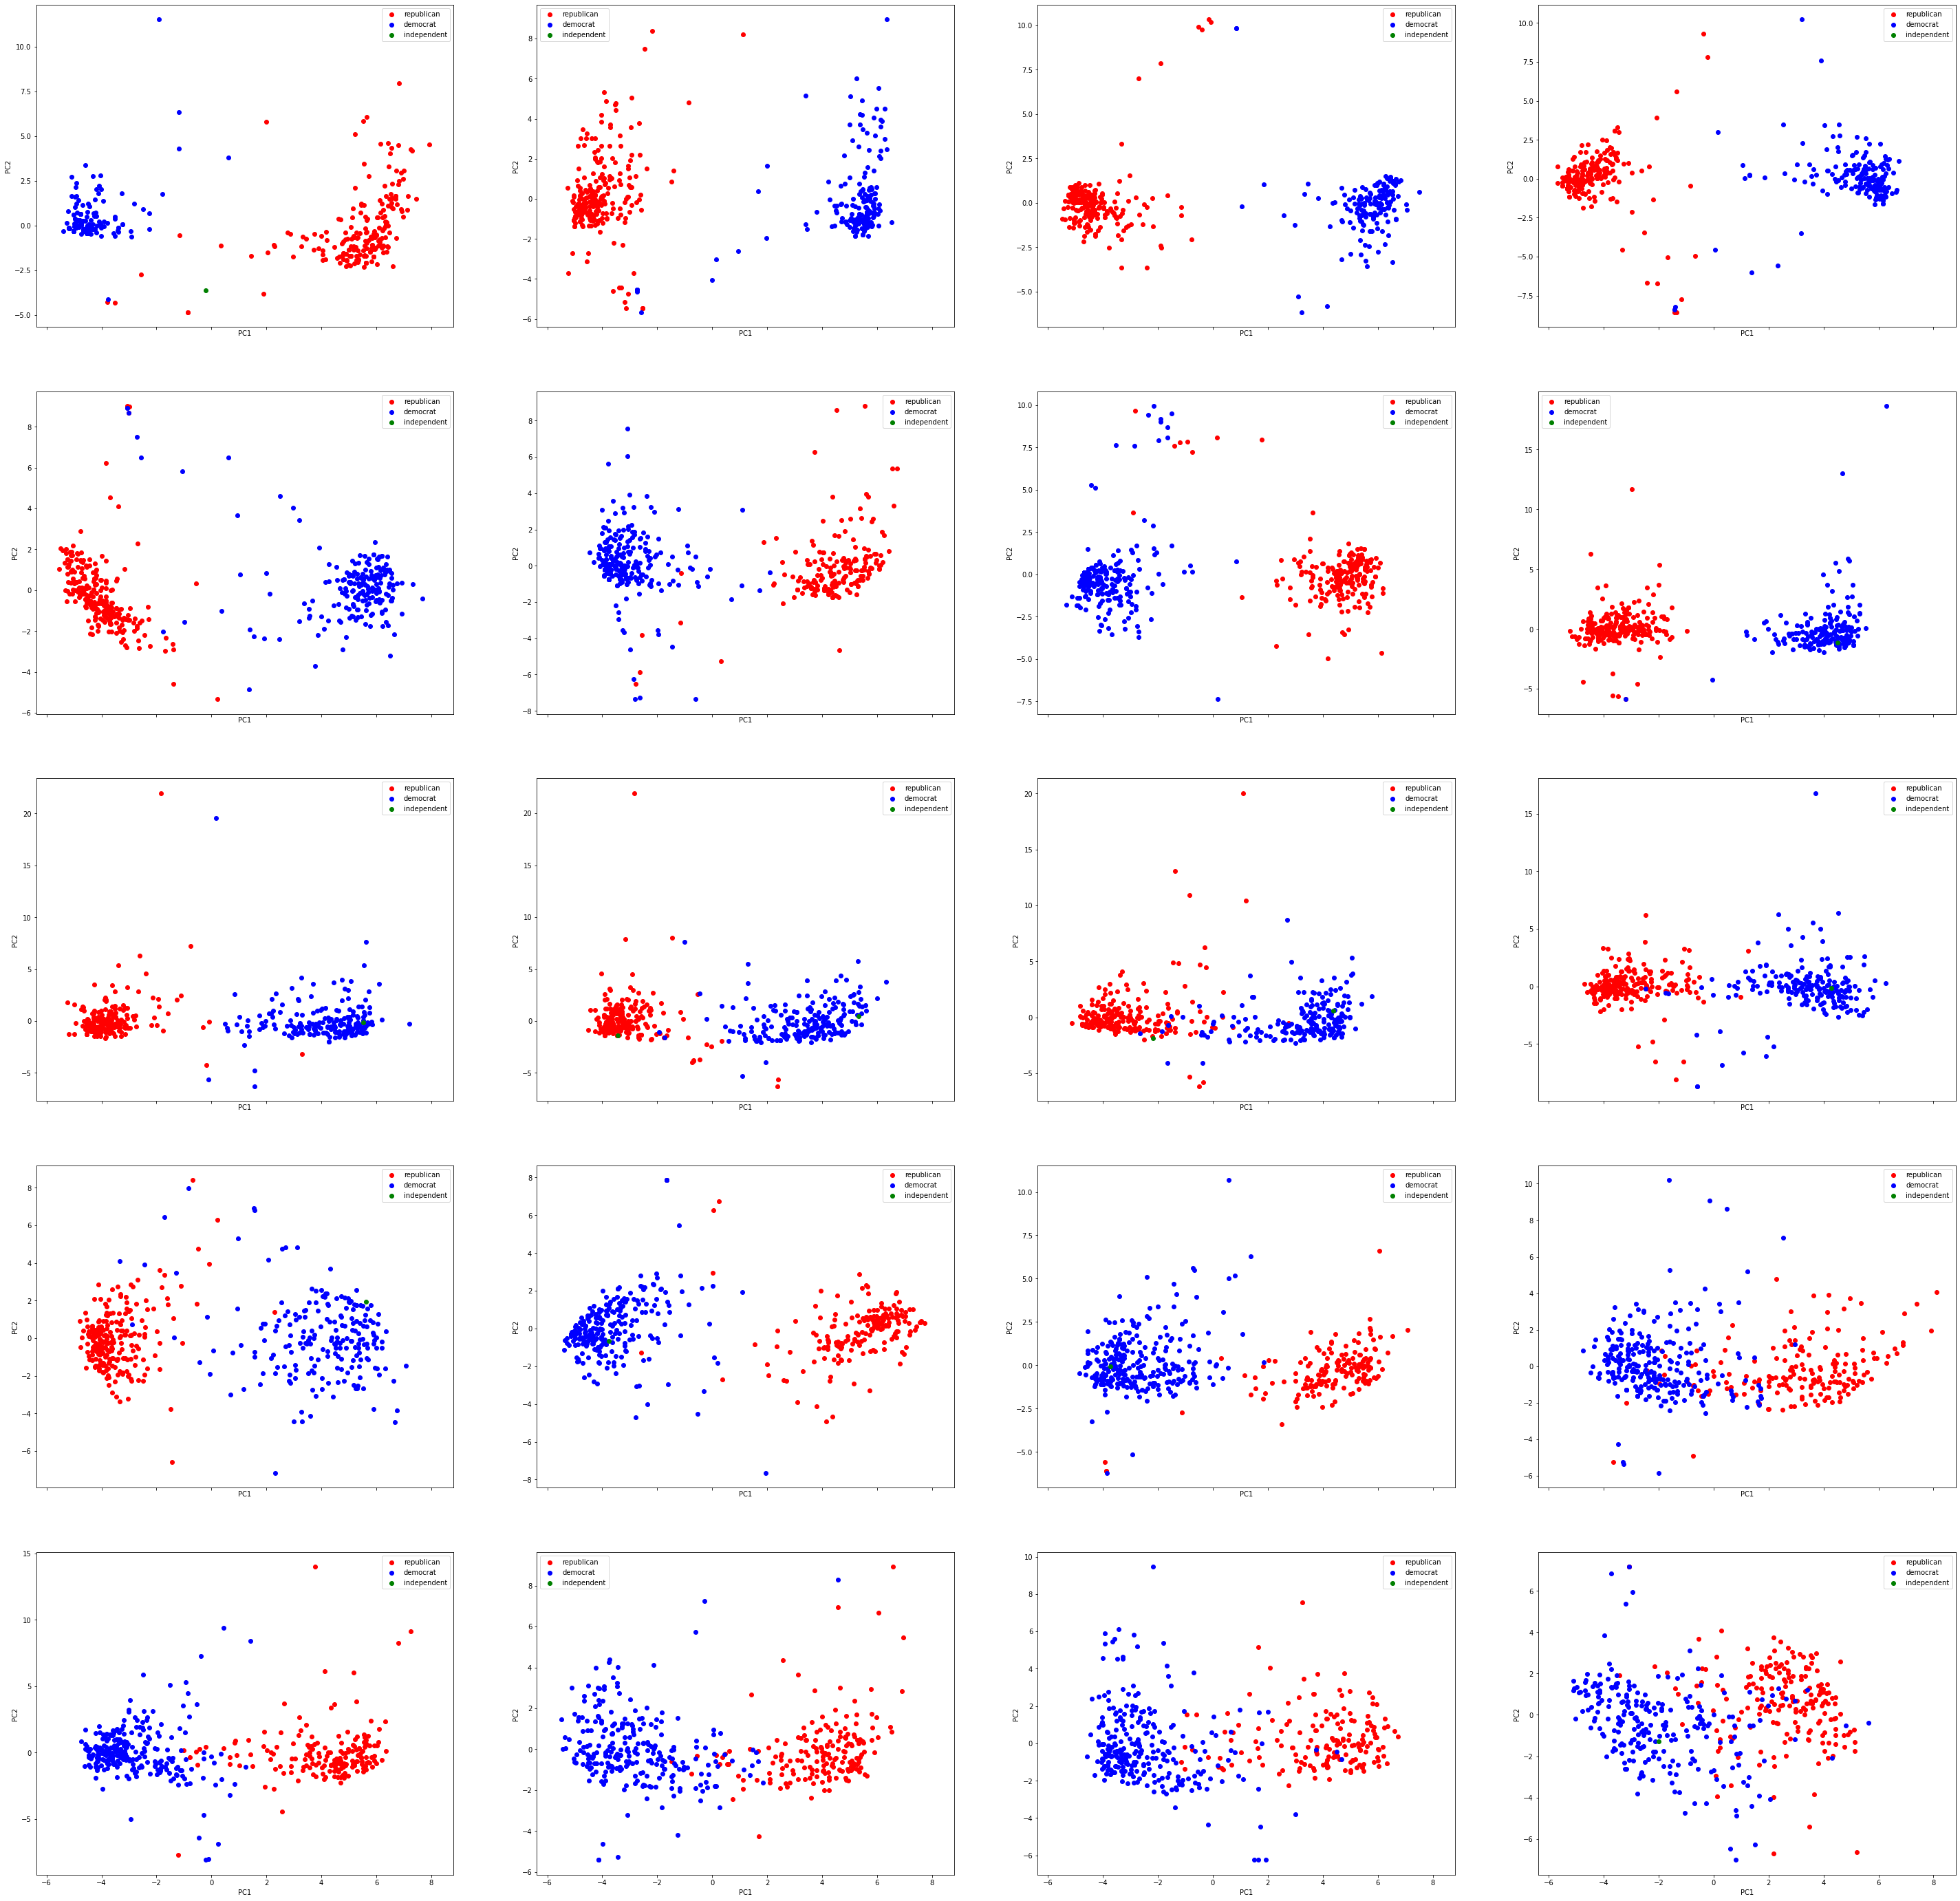

In [211]:
fig,ax=plt.subplots(5,4,sharex=True,figsize=(50,50))
for i in range(5):
    for j in range(4):
        file_name=f"H{116-(i*4+j)}_votes.csv"
        data_frame=pd.read_csv(f"p5-data/congress/{file_name}")
        data_frame_cut=data_frame.iloc[:,8:]
        data_frame_trans=StandardScaler().fit_transform(data_frame_cut)
        data_frame_trans=pd.DataFrame(data_frame_trans,columns=data_frame_cut.columns)


        pca = PCA()
        pca.fit(data_frame_trans)
        X=pca.transform(data_frame_trans)

        color_map={200:"r",100:"b",328:"g"}
        label_map={200:"republican",100:"democrat",328:"independent"}

        for code in [200,100,328]:
            index=np.where(data_frame['PartyCode']==code)
            ax[i][j].scatter(X[index,0],X[index,1],c=color_map[code],label=label_map[code])

        ax[i][j].set_xlabel('PC1')
        ax[i][j].set_ylabel('PC2')
        ax[i][j].legend()